In [41]:
import autograd
import autograd.numpy as np
import matplotlib.pyplot as plt

In [42]:
def find_seed(g, c=0, eps=2**(-26)):
    # dichotomie de g(t) fonction de une variale
    a,b=0,1
    if (g(a)-c)*(g(b)-c)>0:
        return None
    while (b-a)/2 >= eps:
        
        t=a+b/2
        if (g(a)-c)*(g(b)-c)<=0:
            b=t
        else:
            a=t
        
    return (a+b/2)

In [61]:
def simple_contour1(f, c=0.0, delta=0.01):    #essai simple suivi de la ligne de niveau avec gradient
    def grad_f(x,y):
        g=autograd.grad
        return np.r_[g(f,0)(x,y), g(f,1)(x,y)]
    
    x,y = 0.,find_seed(lambda t : f(0.,t))
    X=[x]
    Y=[y]
    for k in range(1000):
        x,y = x - delta*(grad_f(x,y)[1]),y + delta*(grad_f(x,y)[0])
        X.append(x)
        Y.append(y)
    return X,Y

In [62]:
def h(x,y):
    return x**2 + y**2 - 0.5
simple_contour1(h, 1.0)

([0.0,
  -0.015,
  -0.03,
  -0.044994,
  -0.059976,
  -0.0749400024,
  -0.0898800144,
  -0.10479005039904,
  -0.11966413439232,
  -0.13449630236544038,
  -0.14928060468480384,
  -0.16401110848322112,
  -0.17868190003976447,
  -0.19328708715291454,
  -0.2078208015060487,
  -0.2222772010243217,
  -0.23665047222199226,
  -0.2509348325392531,
  -0.26512453266762515,
  -0.2792138588629815,
  -0.2931971352452708,
  -0.3070687260840149,
  -0.3208230380686609,
  -0.33445452256287334,
  -0.34795767784185827,
  -0.3613270513118181,
  -0.37455724171064114,
  -0.38764290128893947,
  -0.40057873797055354,
  -0.413359517491652,
  -0.4259800655175623,
  -0.4384352697364759,
  -0.45072008192918245,
  -0.4628295200139944,
  -0.4747586700660347,
  -0.48650268831006943,
  -0.49805680308607775,
  -0.509416316786762,
  -0.5205766077662118,
  -0.5315331322189469,
  -0.5422814260285755,
  -0.5528171065853166,
  -0.5631358745716463,
  -0.5732335157153418,
  -0.5831059025092086,
  -0.5927489958967893,
  -0.602

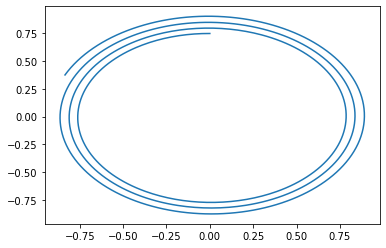

In [63]:
plt.plot(simple_contour1(h, 1.0)[0],simple_contour1(h, 1.0)[1])
plt.show()

In [64]:
def simple_contour2(f, c=0.0, delta=0.01):
    x,y = 0.,find_seed(lambda t : f(0.,t))
    X=[x]
    Y=[y]
    for k in range(1000):
        x+=delta
        y=find_seed(lambda t : f(x,t))
        X.append(x)
        Y.append(y)
    return X,Y
    

In [50]:
def h(x,y):
    return x**2 + y**2

In [53]:
simple_contour2(h, 1.0)

([0.0,
  0.01,
  0.02,
  0.03,
  0.04,
  0.05,
  0.060000000000000005,
  0.07,
  0.08,
  0.09,
  0.09999999999999999,
  0.10999999999999999,
  0.11999999999999998,
  0.12999999999999998,
  0.13999999999999999,
  0.15,
  0.16,
  0.17,
  0.18000000000000002,
  0.19000000000000003,
  0.20000000000000004,
  0.21000000000000005,
  0.22000000000000006,
  0.23000000000000007,
  0.24000000000000007,
  0.25000000000000006,
  0.26000000000000006,
  0.2700000000000001,
  0.2800000000000001,
  0.2900000000000001,
  0.3000000000000001,
  0.3100000000000001,
  0.3200000000000001,
  0.3300000000000001,
  0.34000000000000014,
  0.35000000000000014,
  0.36000000000000015,
  0.37000000000000016,
  0.38000000000000017,
  0.3900000000000002,
  0.4000000000000002,
  0.4100000000000002,
  0.4200000000000002,
  0.4300000000000002,
  0.4400000000000002,
  0.45000000000000023,
  0.46000000000000024,
  0.47000000000000025,
  0.48000000000000026,
  0.49000000000000027,
  0.5000000000000002,
  0.5100000000000002,

SyntaxError: invalid syntax (<ipython-input-22-335f0a0517c2>, line 1)

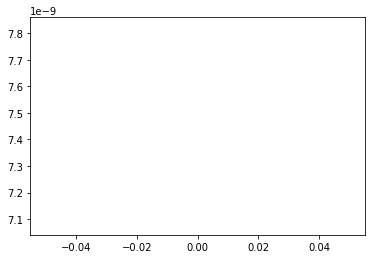

In [51]:
plt.plot(simple_contour2(h, 1.0)[0],simple_contour2(h, 1.0)[1])
plt.show()

In [37]:
def find_seedbis(g, a0, b0, c=0, eps=2**(-26)):
    if (g(a0)-c)*(g(b0)-c)>0:
        return None
    a,b=a0,b0
    while (b-a)/2 >= eps:
        
        t=a+b/2
        if (g(a)-c)*(g(b)-c)<=0:
            b=t
        else:
            a=t
        
    return (a+b/2)

In [10]:
def simple_contourbis(f, a0, b0, c=0.0, delta=0.01):
    x,y = a0,find_seedbis(lambda t : f(a0,t), a0, b0)
    X=[x]
    Y=[y]
    for k in range(1000):
        x,y = x - delta*(grad_f(x,y)[1]),y + delta*(grad_f(x,y)[0])
        X.append(x)
        Y.append(y)
    return X,Y

In [ ]:
def contour(f, c=0.0, xc=[0.0,1.0], yc=[0.0,1.0], delta=0.01):
    for x,y in zip(x)
    